# Interpreting text models:  IMDB sentiment analysis

This notebook loads pretrained CNN model for sentiment analysis on IMDB dataset. It makes predictions on test samples and interprets those predictions using integrated gradients method.

The model was trained using an open source sentiment analysis tutorials described in: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

**Note:** Before running this tutorial, please install: 
- spacy package, and its NLP modules for English language (https://spacy.io/usage)
- sentencpiece (https://pypi.org/project/sentencepiece/)

In [1]:
import spacy

In [2]:
import torch
import torchtext
import torchtext.data

In [3]:
import torch.nn as nn
import torch.nn.functional as F

from torchtext.vocab import Vocab

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

nlp = spacy.load('en')


In [4]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

The dataset used for training this model can be found in: https://ai.stanford.edu/~amaas/data/sentiment/

Redefining the model in order to be able to load it.


In [5]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)


Loads pretrained model and sets the model to eval mode. The model is already in the provided in the 'models' folder. 

Download source: https://github.com/pytorch/captum/blob/master/tutorials/models/imdb-model-cnn.pt

In [6]:
model = torch.load('models/imdb-model-cnn.pt')
model.eval()
model = model.to(device)

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attr

Load a small subset of test data using torchtext from IMDB dataset.

In [42]:
TEXT = torchtext.data.Field(lower=True, tokenize='spacy')
Label = torchtext.data.LabelField(dtype = torch.float)


Download IMDB file 'aclImdb_v1.tar.gz' from https://ai.stanford.edu/~amaas/data/sentiment/ in a 'data' subfolder where this notebook is saved.

Then unpack file using 'tar -xzf aclImdb_v1.tar.gz'

In [43]:
train, test = torchtext.datasets.IMDB.splits(text_field=TEXT,
                                      label_field=Label,
                                      train='train',
                                      test='test',
                                      path='data/aclImdb')
test, _ = test.split(split_ratio = 0.04)

In [45]:
len(test.examples)

# expected result: 1000

1000

Loading and setting up vocabulary for word embeddings using torchtext.

In [46]:
from torchtext import vocab

loaded_vectors = vocab.GloVe(name='6B', dim=50)

# If you prefer to use pre-downloaded glove vectors, you can load them with the following two command line
# loaded_vectors = torchtext.vocab.Vectors('data/glove.6B.50d.txt')

# source for downloading: https://github.com/uclnlp/inferbeddings/tree/master/data/glove

TEXT.build_vocab(train, vectors=loaded_vectors, max_size=len(loaded_vectors.stoi))
    
TEXT.vocab.set_vectors(stoi=loaded_vectors.stoi, vectors=loaded_vectors.vectors, dim=loaded_vectors.dim)
Label.build_vocab(train)


In [143]:
print('Vocabulary Size: ', len(TEXT.vocab))

# expected result: 101982

Vocabulary Size:  101982


Define the padding token. The padding token will also serve as the reference/baseline token used for the application of the Integrated Gradients. The padding token is used for this since it is one of the most commonly used references for tokens.

This is then used with the Captum helper class `TokenReferenceBase` further down to generate a reference for each input text using the number of tokens in the text and a reference token index.

In [144]:
PAD = 'pad'
PAD_INDEX = TEXT.vocab.stoi[PAD]

print(PAD, PAD_INDEX)

pad 6976


Let's create an instance of `LayerIntegratedGradients` using forward function of our model and the embedding layer.
This instance of layer integrated gradients will be used to interpret movie rating review.

Layer Integrated Gradients will allow us to assign an attribution score to each word/token embedding tensor in the movie review text. We will ultimately sum the attribution scores across all embedding dimensions for each word/token in order to attain a word/token level attribution score.

Note that we can also use `IntegratedGradients` class instead, however in that case we need to precompute the embeddings and wrap Embedding layer with `InterpretableEmbeddingBase` module. This is necessary because we cannot perform input scaling and subtraction on the level of word/token indices and need access to the embedding layer.

In [145]:
lig = LayerIntegratedGradients(model, model.embedding)

In the cell below, we define a generic function that generates attributions for each movie rating and stores them in a list using `VisualizationDataRecord` class. This will ultimately be used for visualization purposes.

In [146]:
def interpret_sentence(model, sentence, min_len = 7, label = 0):
    
    # create input tensor from sentence
    text_list = sentence_to_wordlist(sentence, min_len)
    text_tensor, reference_tensor = wordlist_to_tensors(text_list)
   
    # apply model forward function with sigmoid
    model.zero_grad()
    pred = torch.sigmoid(model(text_tensor)).item()
    pred_ind = round(pred)
    
    # compute attributions and approximation delta using layer integrated gradients
    attributions, delta = lig.attribute(text_tensor, reference_tensor, \
                                           n_steps=500, return_convergence_delta = True)

    print('pred: ', Label.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # create and return data visualization record
    return visualization.VisualizationDataRecord(
        attributions,
        pred,
        Label.vocab.itos[pred_ind],
        Label.vocab.itos[label],
        Label.vocab.itos[1],
        attributions.sum(),       
        text_list,
        delta)
    
    # add_attributions_to_visualizer(attributions, text_list, pred, pred_ind, label, delta, vis_data_records_ig)

def sentence_to_wordlist(sentence, min_len = 7):
    # convert sentence into list of word/tokens (using spacy tokenizer)
    text = [tok.text for tok in nlp.tokenizer(sentence)]
    
    # fill text up with 'pad' tokens
    if len(text) < min_len:
        text += [PAD] * (min_len - len(text))
    
    return text

def wordlist_to_tensors(text):
    # get list of token/word indices using the vocabulary
    sentence_indices = [TEXT.vocab.stoi[t] for t in text]
    
    # transform token indices list into torch tensor
    sentence_tensor = torch.tensor(sentence_indices, device=device)
    sentence_tensor = sentence_tensor.unsqueeze(0)

    # create reference tensor using the padding token (one of the most frequently used tokens)
    token_reference = TokenReferenceBase(reference_token_idx = PAD_INDEX)
    reference_tensor = token_reference.generate_reference(len(text), device=device).unsqueeze(0)
    
    return sentence_tensor, reference_tensor


Below cells call `interpret_sentence` to interpret a couple handcrafted review phrases.

In [147]:
# reset accumulated data
vis_records = []

vis_records.append(interpret_sentence(model, 'It was a fantastic performance !', label=1))
vis_records.append(interpret_sentence(model, 'Best film ever', label=1))
vis_records.append(interpret_sentence(model, 'Such a great show!', label=1))
vis_records.append(interpret_sentence(model, 'I\'ve never watched something as bad', label=0))
vis_records.append(interpret_sentence(model, 'It is a disgusting movie!', label=0))
vis_records.append(interpret_sentence(model, 'Makes a poorly convincing argument', label=0))
vis_records.append(interpret_sentence(model, 'Makes a fairly convincing argument', label=1))
vis_records.append(interpret_sentence(model, 'Skyfall is one of the best action film in recent years but is just too long', min_len=18, label=1))


pred:  pos ( 0.99 ) , delta:  tensor([0.0007])
pred:  pos ( 0.71 ) , delta:  tensor([0.0001])
pred:  pos ( 0.95 ) , delta:  tensor([0.0003])
pred:  neg ( 0.22 ) , delta:  tensor([0.0012])
pred:  neg ( 0.38 ) , delta:  tensor([0.0005])
pred:  neg ( 0.01 ) , delta:  tensor([0.0005])
pred:  pos ( 0.66 ) , delta:  tensor([0.0003])
pred:  pos ( 0.91 ) , delta:  tensor([0.0034])


Below is an example of how we can visualize attributions for the text tokens. Feel free to visualize it differently if you choose to have a different visualization method.

In [148]:
vis_example = vis_records[-1]
# print(dir(vis_example))

print('raw input: ', vis_example.raw_input)
print('true class: ', vis_example.true_class)
print('pred class (prob): ', vis_example.pred_class, '(', vis_example.pred_prob, ')')
print('attr score (sum over word attributions): ', vis_example.attr_score)
print('word attributions\n', vis_example.word_attributions)

raw input:  ['Skyfall', 'is', 'one', 'of', 'the', 'best', 'action', 'film', 'in', 'recent', 'years', 'but', 'is', 'just', 'too', 'long', 'pad', 'pad']
true class:  pos
pred class (prob):  pos ( 0.912595808506012 )
attr score (sum over word attributions):  0.7669921
word attributions
 [ 0.01238924  0.06156125  0.12204969  0.01363888 -0.00212131  0.8445496
  0.12998587  0.2656981  -0.05432949 -0.01857009  0.17297307 -0.08786825
 -0.08167404 -0.2637743  -0.13738513 -0.21013089  0.          0.        ]


In [149]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_records)


Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.99),pos,1.55,It was a fantastic performance ! pad
pos,pos (0.71),pos,1.69,Best film ever pad pad pad pad
pos,pos (0.95),pos,1.55,Such a great show ! pad pad
neg,neg (0.22),pos,-1.72,I 've never watched something as bad
neg,neg (0.38),pos,-1.29,It is a disgusting movie ! pad
neg,neg (0.01),pos,-1.32,Makes a poorly convincing argument pad pad
pos,pos (0.66),pos,1.27,Makes a fairly convincing argument pad pad
pos,pos (0.91),pos,0.77,Skyfall is one of the best action film in recent years but is just too long pad pad


Above cell generates an output similar to this:

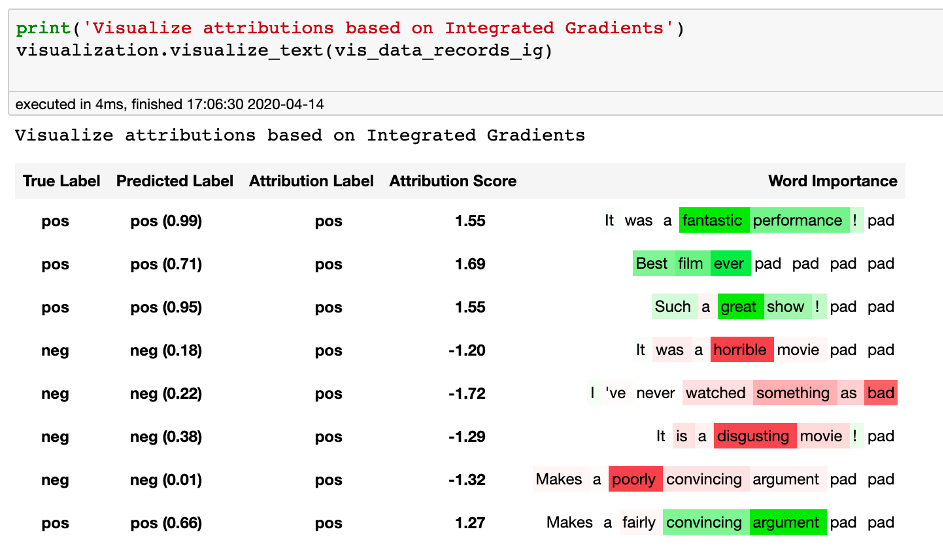

In [129]:
from IPython.display import Image
Image(filename='img/sentiment_analysis.png')
